In [1]:
import numpy as np
import skimage as sk
from pyswarm import pso
from sklearn.cluster import KMeans
import pandas as pd

In [2]:
def clustering_cost(m, X):
    """
    Funkce rozdělí data k nejbližším clusterům na základě vzdálenosti od středu clusteru.
    Vrátí sumu meziclusterové vzdálenosti.
    """
    # reshapne matici m na matici se středy clusterů    
    cluster_centers = m.reshape(3, -1).T  # Transpose for column-wise centers

    # párová vzdálenost mezi daty středy clusterů
    distances = np.linalg.norm(X[:, np.newaxis, :] - cluster_centers, axis=2)

    # přiřadí data k nejbližším clusterům a spočítá nejmenší vzdálenosti
    closest_distances = np.min(distances, axis=1)

    return np.sum(closest_distances)

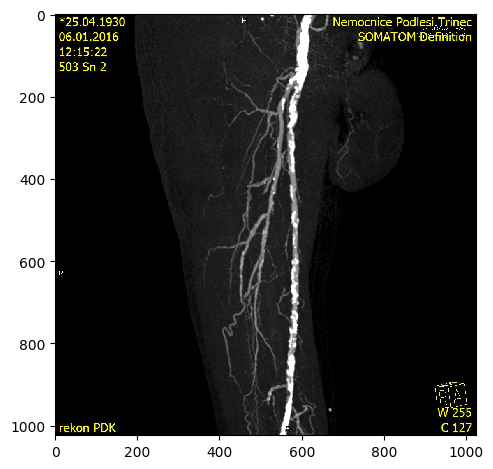

In [3]:
# načtení obrazu
calcif = sk.io.imread("kalcifikace.jpg")
rows, cols, channels = calcif.shape
rChannel = calcif[..., 0] # rozdělení chromatických kanálů
gChannel = calcif[..., 1]
bChannel = calcif[..., 2]
sk.io.imshow(calcif)
sk.io.show()

In [8]:
# extrakce chromatických kanálů jako příznaky
x1 = (rChannel - np.min(rChannel)) / (np.max(rChannel) - np.min(rChannel))
x2 = (gChannel - np.min(gChannel)) / (np.max(gChannel) - np.min(gChannel))
x3 = (bChannel - np.min(bChannel)) / (np.max(bChannel) - np.min(bChannel))
x = np.array([x1.ravel(), x2.ravel(), x3.ravel()]).T

In [13]:
clusters = 6
varSize = np.array([clusters, x.shape[1]])
nVar = np.prod(varSize)
varMin = np.tile(np.min(x, axis=0), (clusters, 1))
varMax = np.tile(np.max(x, axis=0), (clusters, 1))

# anonymní funkce pro optimalizaci clusterů
clusteringCost = lambda m: clustering_cost(m, x)

In [14]:
# optimalizace středů clusterů
centers, err_ga = pso(clusteringCost, varMin.flatten(), varMax.flatten(),
                      swarmsize=10, maxiter=10)
centers = centers.reshape(clusters, -1)

Stopping search: maximum iterations reached --> 10


c:\Users\vojte\Desktop\skola\AUI\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


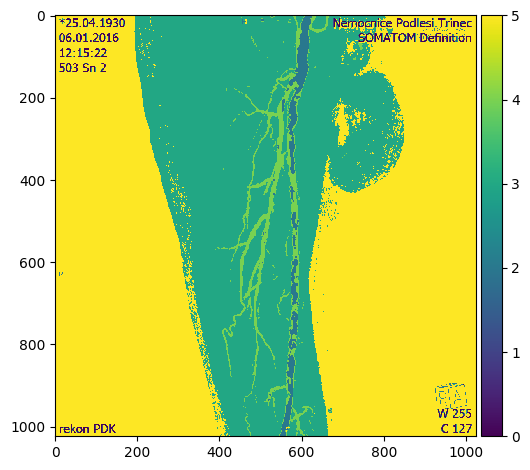

In [15]:
# segmentace obrazu na základě optimalizovaných clusterů
kmeans = KMeans(n_clusters=clusters, init=centers, n_init=1, random_state=0)
ind = kmeans.fit_predict(x)
outImage = ind.reshape(calcif.shape[:2]).astype(np.uint8)
sk.io.imshow(outImage, cmap="viridis")
sk.io.show()

c:\Users\vojte\Desktop\skola\AUI\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


,perimeter,area
0,2526.570814,12195.0


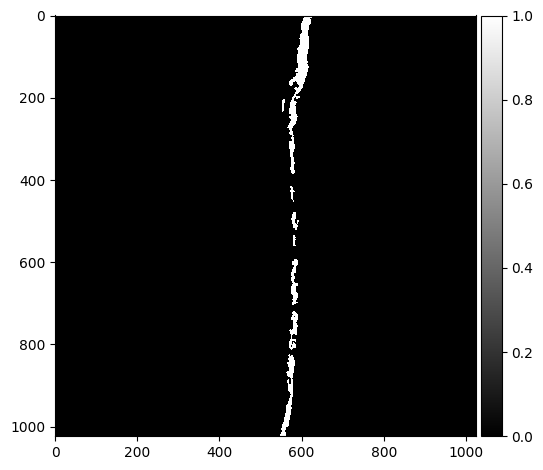

In [18]:
# výpočet obsahu, obvodu kalcifikace
calcLabel = 2
mask = sk.morphology.remove_small_objects(outImage == calcLabel, 35).astype(np.uint8)
props = sk.measure.regionprops_table(mask, outImage, properties=["perimeter", "area"])
propsTable = pd.DataFrame(props)
sk.io.imshow(mask, cmap="gray")
propsTable